In [1]:
#Importing required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
import statsmodels.formula.api as smf
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import sys
sys.path.append('../FairnessPipeline-BankMarketing/')  # Adjust the path as necessary

In [82]:
#Importing and displaying data
data = pd.read_csv("../data/raw/raw_df.csv")

# Create age buckets
# bins = [0, 18, 25, 35, 45, 55, 65, float('inf')]
# labels = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64','65+']
# data['age_bucket'] = pd.cut(X_test['age'], bins=bins, labels=labels)

data_new = pd.get_dummies(data, columns=['job','marital',
                                        #  'age_bucket',
                                         'education','default',
                                         'housing','loan',
                                         'contact','month',
                                         'poutcome'])

data_new.y.replace(('yes', 'no'), (1, 0), inplace=True)

data_y = pd.DataFrame(data_new['y'])
data_X = data_new.drop([
                        # 'age',
                        'y'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.3, random_state=2, stratify=data_y)

from xgboost import XGBClassifier
clf = XGBClassifier()

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [54]:
X_test.columns

Index(['Unnamed: 0', 'age', 'balance', 'day_of_week', 'duration', 'campaign',
       'pdays', 'previous', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'marital_divorced', 'marital_married',
       'marital_single', 'education_primary', 'education_secondary',
       'education_tertiary', 'default_no', 'default_yes', 'housing_no',
       'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_feb',
       'month_jan', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_oct', 'month_sep', 'poutcome_failure',
       'poutcome_other', 'poutcome_success'],
      dtype='object')

In [56]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred))

0.9076231200235919


In [57]:
from fairlearn.metrics import MetricFrame, selection_rate

In [59]:
X_test['age_bucket_65+'] = (X_test['age'] >= 65)

# Compute MetricFrame
mitigated_metric_frame = MetricFrame(metrics={
    'accuracy': metrics.accuracy_score,
    'selection_rate': selection_rate
},
y_true=y_test,
y_pred=y_pred,
sensitive_features=X_test['age_bucket_65+'])

# Print the metrics by group
print(mitigated_metric_frame.by_group)

                accuracy  selection_rate
age_bucket_65+                          
False           0.911610        0.091169
True            0.693548        0.346774


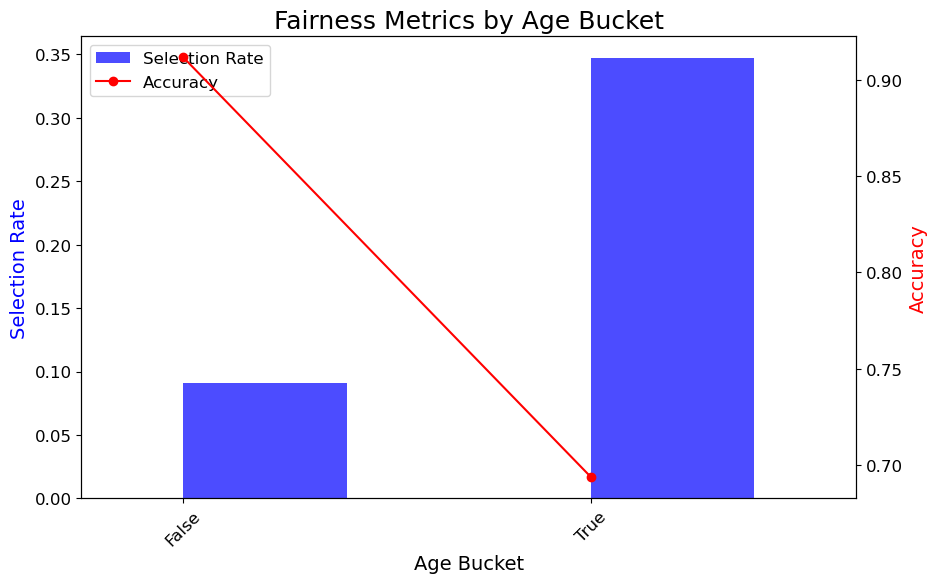

In [60]:
metrics = ['selection_rate', 'accuracy']
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the selection rate as bar plot
mitigated_metric_frame.by_group['selection_rate'].plot(kind='bar', ax=ax1, color='b', alpha=0.7, position=0, width=0.4, label='Selection Rate')

# Create a second y-axis for the F1 score
ax2 = ax1.twinx()
mitigated_metric_frame.by_group['accuracy'].plot(kind='line', ax=ax2, color='r', label='Accuracy', marker='o')

# Set titles and labels with larger font sizes
ax1.set_title('Fairness Metrics by Age Bucket', fontsize=18)
ax1.set_xlabel('Age Bucket', fontsize=14)
ax1.set_ylabel('Selection Rate', fontsize=14, color='b')
ax2.set_ylabel('Accuracy', fontsize=14, color='r')

# Set tick parameters
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)

# Rotate x-axis labels
ax1.set_xticklabels(mitigated_metric_frame.by_group.index, rotation=45, fontsize=12)

# Create a legend with larger font size
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=12)

plt.show()

# Mitigated

In [87]:
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity

data = pd.read_csv("../data/raw/raw_df.csv")

# Create age buckets
data_new = pd.get_dummies(data, columns=['job','marital',
                                         'education','default',
                                         'housing','loan',
                                         'contact','month',
                                         'poutcome'])

data_new.y.replace(('yes', 'no'), (1, 0), inplace=True)

data_y = pd.DataFrame(data_new['y'])
data_X = data_new.drop(['y'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.3, random_state=2, stratify=data_y)

clf = XGBClassifier()

In [83]:

# Initialize the mitigator with the model and fairness constraint
mitigator = ExponentiatedGradient(clf,
                                  constraints=DemographicParity(),
                                  eps=0.07,
                                  )

# Fit the mitigator on the training data
mitigator.fit(X_train, y_train, sensitive_features=X_train['age'])

# Predict with the mitigated model
y_pred_mitigated = mitigator.predict(X_test)

In [ ]:
mitigator.save_model

In [84]:
X_test['age_bucket_65+'] = (X_test['age'] >= 65)

In [88]:
# Compute MetricFrame
mitigated_metric_frame_post_mitigation = MetricFrame(metrics={
    'accuracy': accuracy_score,
    'f1' :f1_score,
    'selection_rate': selection_rate
},
y_true=y_test,
y_pred=y_pred_mitigated,
sensitive_features=X_test['age_bucket_65+'])

# Print the metrics by group
print(mitigated_metric_frame_post_mitigation.by_group)

                accuracy        f1  selection_rate
age_bucket_65+                                    
False           0.912136  0.591480        0.104010
True            0.576613  0.198473        0.092742


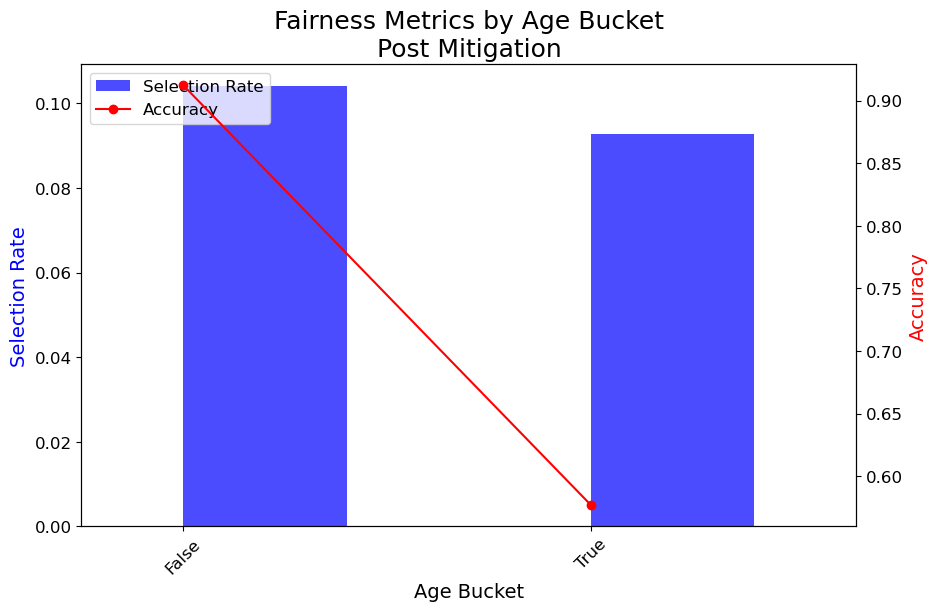

In [86]:
metrics = ['selection_rate', 'accuracy']
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the selection rate as bar plot
mitigated_metric_frame_post_mitigation.by_group['selection_rate'].plot(kind='bar', ax=ax1, color='b', alpha=0.7, position=0, width=0.4, label='Selection Rate')

# Create a second y-axis for the F1 score
ax2 = ax1.twinx()
mitigated_metric_frame_post_mitigation.by_group['accuracy'].plot(kind='line', ax=ax2, color='r', label='Accuracy', marker='o')

# Set titles and labels with larger font sizes
ax1.set_title('Fairness Metrics by Age Bucket\nPost Mitigation', fontsize=18)
ax1.set_xlabel('Age Bucket', fontsize=14)
ax1.set_ylabel('Selection Rate', fontsize=14, color='b')
ax2.set_ylabel('Accuracy', fontsize=14, color='r')

# Set tick parameters
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)

# Rotate x-axis labels
ax1.set_xticklabels(mitigated_metric_frame_post_mitigation.by_group.index, rotation=45, fontsize=12)

# Create a legend with larger font size
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=12)

plt.show()